In [1]:
 !pip install ultralytics 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 16.7 MB/s eta 0:00:00a 0:00:01


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from shutil import rmtree, copyfile

import yaml

In [3]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
RANDOM = 20241203
IMAGE_H = 1486
IMAGE_W = 2048

cmap = plt.get_cmap('tab20').colors

### Sample

In [5]:
sample_submission = pd.read_csv('/kaggle/input/waste-detection/sample_submission.csv')
with pd.option_context('display.max_colwidth', None):
  display(sample_submission)

file_name  \
0     000003.jpg   
1     000006.jpg   
2     000013.jpg   
3     000016.jpg   
4     000019.jpg   
...          ...   
2994  008986.jpg   
2995  008989.jpg   
2996  008991.jpg   
2997  008995.jpg   
2998  008998.jpg   

                                                                                            bbox  
0         [[5.0, 0.64, 536.1, 76.56, 834.52, 890.82], [5.0, 0.64, 536.1, 76.56, 834.52, 890.82]]  
1           [[4.0, 0.91, 397.68, 3.2, 218.05, 970.42], [4.0, 0.91, 397.68, 3.2, 218.05, 970.42]]  
2                                                                                             []  
3     [[8.0, 0.89, 587.89, 771.75, 636.26, 337.43], [8.0, 0.89, 587.89, 771.75, 636.26, 337.43]]  
4       [[7.0, 0.68, 75.08, 220.41, 982.22, 794.76], [7.0, 0.68, 75.08, 220.41, 982.22, 794.76]]  
...                                                                                          ...  
2994      [[7.0, 0.1, 402.9, 964.16, 652.63, 273.57], [7.0, 0.1, 402.9, 964.16, 652.63, 273.57]]  
2995    [[4.0, 0.22, 12.38, 247.02, 954.12, 720.33], [4.0, 0.22, 12.38, 247.02, 954.12, 720.33]]  
2996  [[7.0, 0.37, 954.55, 592.88, 619.44, 212.06], [7.0, 0.37, 954.55, 592.88, 619.44, 212.06]]  
2997    [[14.0, 0.83, 185.66, 38.81, 170.07, 87.41], [14.0, 0.83, 185.66, 38.81, 170.07, 87.41]]  
2998    [[5.0, 0.69, 866.59, 814.55, 923.55, 57.19], [5.0, 0.69, 866.59, 814.55, 923.55, 57.19]]  

[2999 rows x 2 columns]

In [6]:
sample_submission.loc[0, 'bbox']

'[[5.0, 0.64, 536.1, 76.56, 834.52, 890.82], [5.0, 0.64, 536.1, 76.56, 834.52, 890.82]]'

### Holdout

In [7]:
holdout_df = pd.read_csv('/kaggle/input/waste-detection/test.csv')
holdout_df

file_name
0     000003.jpg
1     000006.jpg
2     000013.jpg
3     000016.jpg
4     000019.jpg
...          ...
2994  008986.jpg
2995  008989.jpg
2996  008991.jpg
2997  008995.jpg
2998  008998.jpg

[2999 rows x 1 columns]

In [8]:
holdout = list(holdout_df.file_name)

### Class

In [9]:
trash_dict = {
    1: "PET (transparent) (green)",
    2: "PET (transparent) (brown)",
    3: "PET (transparent) (blue)",
    4: "PET (transparent)",
    5: "PET (transparent) (dark blue)",
    6: "PET (black)",
    7: "PET (white)",
    8: "PET (sticker)",
    9: "PET (flacon)",
    10: "PET (household chemicals)",
    11: "PND (household chemicals)",
    12: "PND packet",
    13: "Other plastic",
    14: "Other plastic (transparent)",
    15: "Not plastic"
}

## Samples

In [10]:
#model = YOLO("/kaggle/input/rrenue-best4020/best4020.pt")
model = YOLO("/kaggle/input/renue-train/runs/detect/train22222222222222222222222222222/weights/best.pt")
model.info()

YOLO11m summary: 409 layers, 20,064,573 parameters, 0 gradients, 68.2 GFLOPs


(409, 20064573, 0, 68.24883200000001)

In [ ]:
holdout_img = [os.path.join('/kaggle/input/waste-detection/images', x) for x in holdout]
#holdout_img = holdout_img[:220] #demo
#holdout_img = holdout_img[:1] #demo

In [12]:
with open ('holdout.txt', 'w') as file:
    file.write('\n'.join(holdout_img))

In [13]:
predictions = model('holdout.txt', batch=.9, imgsz=2048, stream=True)


image 1/1 /kaggle/input/waste-detection/images/000003.jpg: 1504x2048 1 PET (transparent) (brown), 1 PET (transparent), 154.4ms


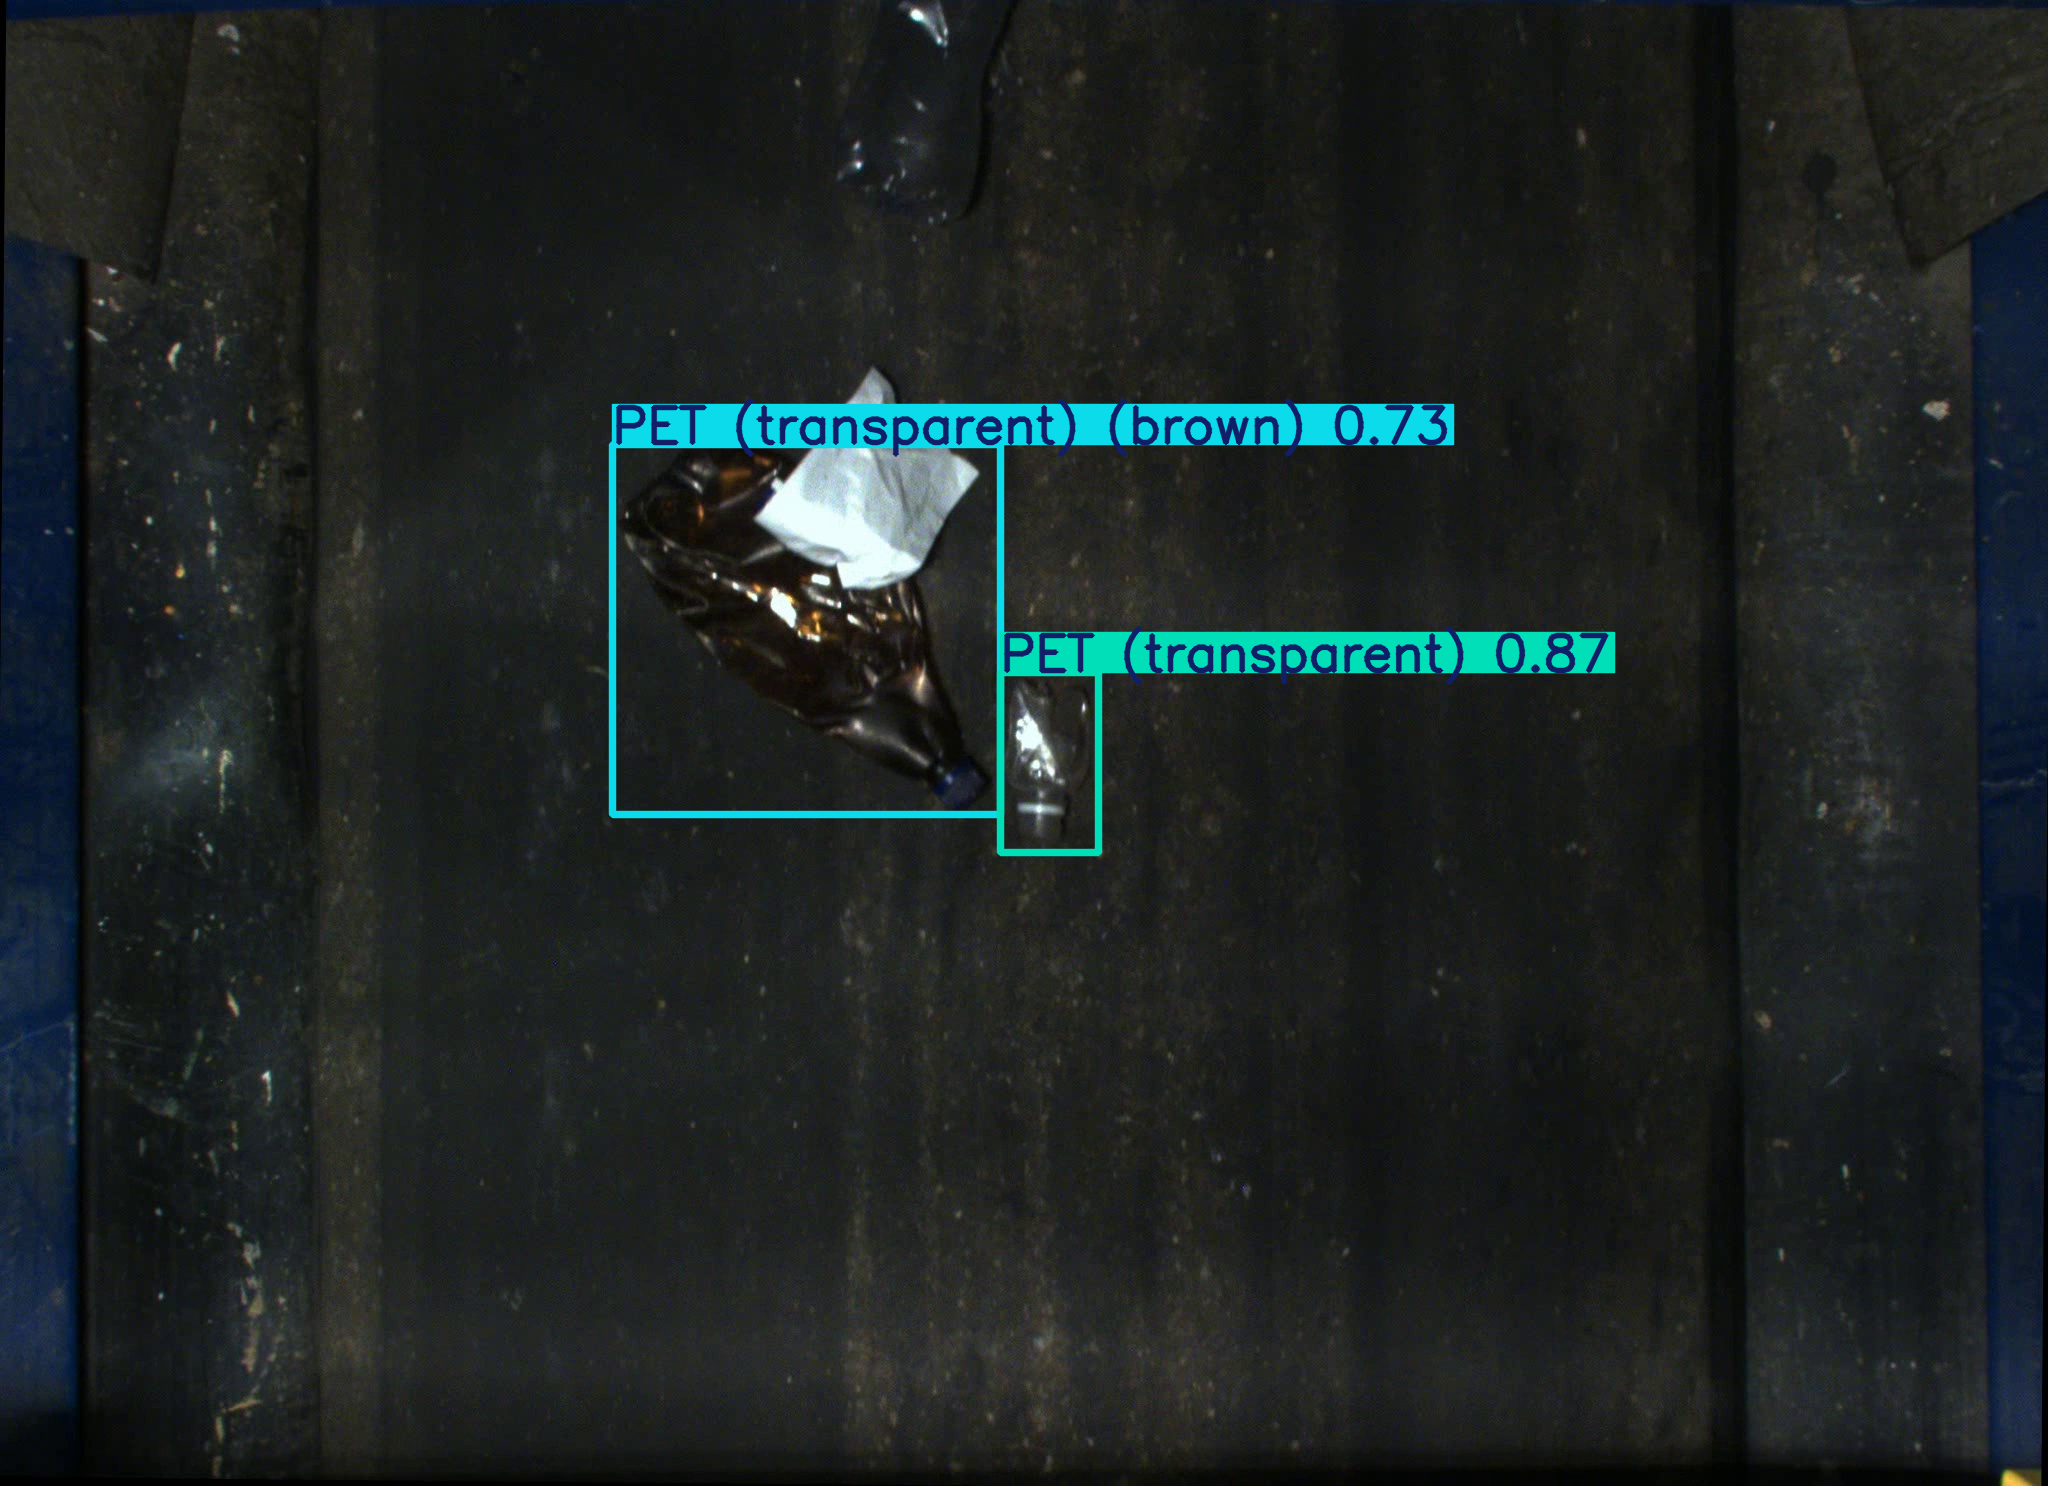

Speed: 16.0ms preprocess, 154.4ms inference, 252.6ms postprocess per image at shape (0.9, 3, 1504, 2048)


In [14]:
long_boxes, output_imgs = [], []
for counter, result in enumerate(predictions):
    if counter%499 == 0:
        result.show()
        output_imgs.append(result.path)
    boxes = result.boxes
    #result.show()
    long_boxes.append(
        str([x+y for x,y in zip(
            list(map(list, zip([x + 1 for x in boxes.cls.tolist()],
                               boxes.conf.tolist()))),
                               [[z[0], z[1], (z[2]-z[0]), (z[3]-z[1])]  for z in boxes.xyxy.tolist()])]))

In [15]:
sample_output = pd.read_csv('/kaggle/input/waste-detection/sample_submission.csv')
output = sample_output.copy()
##output = output.drop('bbox', axis=1)
output.bbox = pd.Series(long_boxes, name='bbox')
output.to_csv('prediction.csv', index=False)

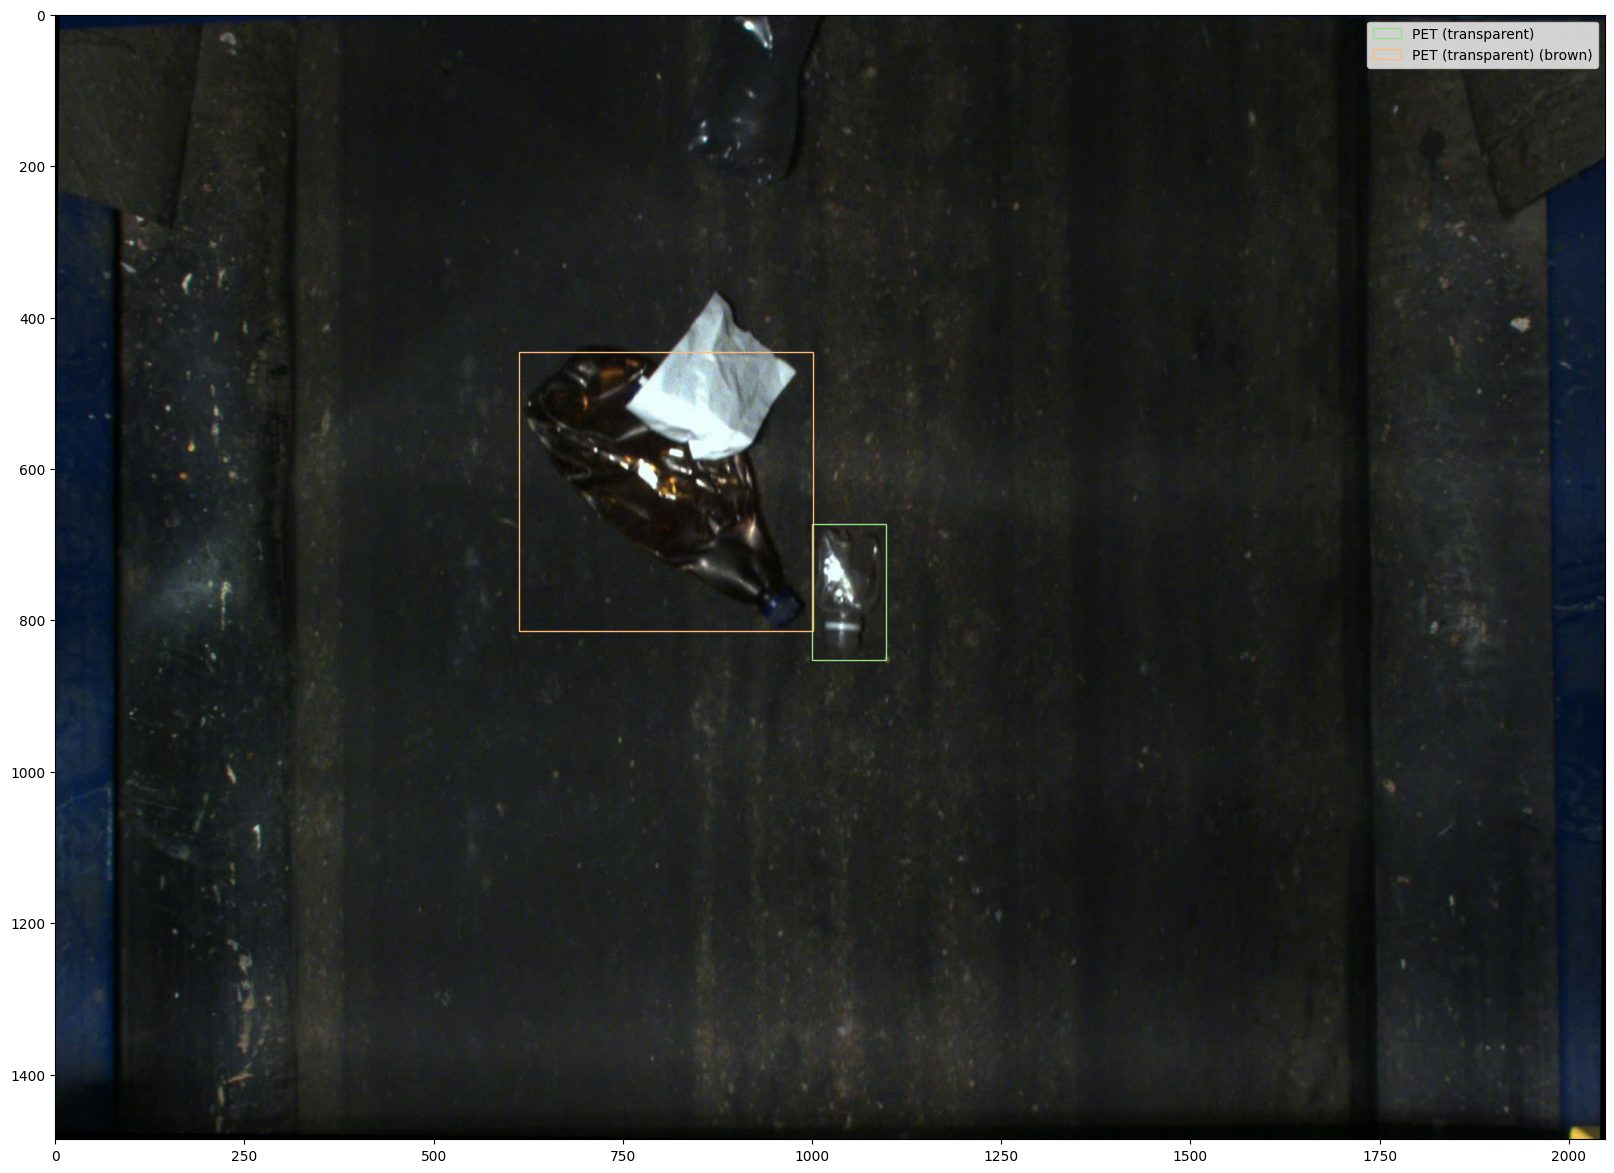

In [16]:
for pic in output_imgs:
    sample_p = pic
    sample_i = Image.open(sample_p)
    sample_fn = os.path.basename(sample_p)
    
    sample_sub = eval(output.query('file_name == @sample_fn')['bbox'].item())
    labels = set([])
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    ax.imshow(sample_i)
    
    for _ in range(len(sample_sub)):
        cat = sample_sub[_][0]
        cat_name = trash_dict[cat]
        label = cat_name if cat_name not in labels else ""
        labels.add(cat_name)
        rect = sample_sub[_][2:]
        rect = [[rect[0], rect[1]], rect[2], rect[3]]
        ax.add_patch(patches.Rectangle(*rect, linewidth=1, edgecolor=cmap[int(cat+1)], facecolor='none', label=label))
        
    
    ax.legend()
    plt.show()